In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import sys
sys.path.append('../')

from utils.processing import *
from utils.visualisation import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, GridSearchCV, train_test_split, validation_curve
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA, TruncatedSVD, SparsePCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import DBSCAN

np.random.seed(0)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 80)

In [4]:
# load data set
df = pd.read_csv('../data/train.csv')
df_train_orig = df.copy()

In [5]:
# Utility functions
def prepare_data_for_regression(df, drop_columns=[]):
    adfs = read_aux_csv('../data')
    df = join_aux(df, adfs)
    df = df.drop(columns=drop_columns)

    return df

def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    score = np.sqrt(mse)
    return score

def rmse_scorer():
    return make_scorer(rmse, greater_is_better=False)

def split_data(df):
    X = df.drop('price', axis=1)
    y = df['price']
    
    return X, y

# Constants
initial_drop_columns = [
    'address',
    'title',
    'listing_id',
    'property_name',
    'available_unit_types',
    'property_details_url',
    'elevation',
    'tenure',
    'property_type',
    'floor_level',
    'furnishing',
]

drop_columns = initial_drop_columns + [
    'area_size',
    'population',
    'subzone',
    'lat',
    'lng',
]

In [6]:
# Baseline model
df_baseline = preprocess(df_train_orig.copy())
df_baseline = prepare_data_for_regression(df_baseline, drop_columns=initial_drop_columns)
df_baseline.head()

,built_year,num_beds,num_baths,size_sqft,total_num_units,lat,lng,subzone,planning_area,price,property_type_private,property_type_public,tenure_high_year,tenure_low_year,floor_level_ground,floor_level_high,floor_level_low,floor_level_mid,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,line_dt,line_ew,line_ne,line_ns,line_te,nearest_pri_sch_distance_in_km,nearest_gep_pri_sch_distance_in_km,gep_pri_sch_within_1km,gep_pri_sch_within_1km_2km,gep_pri_sch_outside_2km,pri_sch_within_500m,pri_sch_outside_500m,nearest_com_centre_distance_in_km,cc_type_BN,cc_type_CR,cc_type_IEBP,cc_type_IHL,nearest_mall_distance_in_km,area_size,population,density,region
0,1988.0,3.0,2.0,1115.0,116.0,1.414399,103.837196,yishun south,yishun,514500.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.574204,0,0,0,0,0,0,1,0,0.275582,6.194099,0,0,1,1,0,3.338999,0,1,0,0,0.621334,1.3402,42240,31517.683928,n
1,1992.0,4.0,2.0,1575.0,NaN,1.372597,103.875625,serangoon north,serangoon,995400.0,0,1,0,1,0,0,0,0,0,0,0,0,1,1.734303,0,0,0,0,0,1,0,0,0.122925,0.122925,1,0,0,1,0,2.401882,1,0,0,0,0.552544,0.6847,15940,23280.268731,ne
2,2022.0,4.0,6.0,3070.0,56.0,1.298773,103.895798,mountbatten,marine parade,8485000.0,1,0,1,0,0,0,1,0,0,0,1,0,0,1.319766,1,0,0,0,0,0,0,0,0.891475,1.872702,0,1,0,0,1,2.171328,1,0,0,0,0.824208,1.7119,9980,5829.779777,c
3,2023.0,3.0,2.0,958.0,638.0,1.312364,103.803271,farrer court,bukit timah,2626000.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.726006,1,0,0,0,0,0,0,0,1.090371,1.090371,0,1,0,0,1,1.605928,1,0,0,0,0.907063,0.5588,6180,11059.413028,c
4,2026.0,2.0,1.0,732.0,351.0,1.273959,103.843635,anson,downtown core,1764000.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.371115,0,0,0,0,1,0,0,0,0.464835,2.742534,0,0,1,1,0,1.869574,0,1,0,0,0.430415,0.1032,80,775.193798,c


In [7]:
X_baseline, y_baseline = split_data(df_baseline)
ct_baseline = make_column_transformer(
                    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "planning_area", "subzone"]),
                    remainder='passthrough')

baseline_regr = make_pipeline(ct_baseline, StandardScaler(), KNNImputer(), DecisionTreeRegressor())
baseline_regr.fit(X_baseline, y_baseline)
baseline_scores = cross_validate(baseline_regr, X_baseline, y_baseline, cv=5, scoring=rmse_scorer())
print(baseline_scores['test_score'].mean())

-2624034.4937721035


In [8]:
# Prepare training data set
df_train = preprocess(df_train_orig.copy())
df_train = prepare_data_for_regression(df_train, drop_columns=drop_columns)
df_train

,built_year,num_beds,num_baths,size_sqft,total_num_units,planning_area,price,property_type_private,property_type_public,tenure_high_year,tenure_low_year,floor_level_ground,floor_level_high,floor_level_low,floor_level_mid,floor_level_penthouse,floor_level_top,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,nearest_mrt_distance_in_km,line_cc,line_ce,line_cg,line_dt,line_ew,line_ne,line_ns,line_te,nearest_pri_sch_distance_in_km,nearest_gep_pri_sch_distance_in_km,gep_pri_sch_within_1km,gep_pri_sch_within_1km_2km,gep_pri_sch_outside_2km,pri_sch_within_500m,pri_sch_outside_500m,nearest_com_centre_distance_in_km,cc_type_BN,cc_type_CR,cc_type_IEBP,cc_type_IHL,nearest_mall_distance_in_km,density,region
0,1988.0,3.0,2.0,1115.0,116.0,yishun,514500.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0.574204,0,0,0,0,0,0,1,0,0.275582,6.194099,0,0,1,1,0,3.338999,0,1,0,0,0.621334,31517.683928,n
1,1992.0,4.0,2.0,1575.0,NaN,serangoon,995400.0,0,1,0,1,0,0,0,0,0,0,0,0,1,1.734303,0,0,0,0,0,1,0,0,0.122925,0.122925,1,0,0,1,0,2.401882,1,0,0,0,0.552544,23280.268731,ne
2,2022.0,4.0,6.0,3070.0,56.0,marine parade,8485000.0,1,0,1,0,0,0,1,0,0,0,1,0,0,1.319766,1,0,0,0,0,0,0,0,0.891475,1.872702,0,1,0,0,1,2.171328,1,0,0,0,0.824208,5829.779777,c
3,2023.0,3.0,2.0,958.0,638.0,bukit timah,2626000.0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.726006,1,0,0,0,0,0,0,0,1.090371,1.090371,0,1,0,0,1,1.605928,1,0,0,0,0.907063,11059.413028,c
4,2026.0,2.0,1.0,732.0,351.0,downtown core,1764000.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.371115,0,0,0,0,1,0,0,0,0.464835,2.742534,0,0,1,1,0,1.869574,0,1,0,0,0.430415,775.193798,c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20140,2026.0,2.0,2.0,635.0,605.0,ang mo kio,1050000.0,1,0,0,1,0,0,0,0,0,0,0,0,1,0.149941,0,0,0,0,0,0,0,1,0.790370,4.691173,0,0,1,0,1,3.163579,0,0,1,0,2.014133,2384.380061,ne
20141,2026.0,2.0,2.0,883.0,137.0,kallang,2087400.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.443603,0,0,0,0,0,1,0,0,0.660929,2.178475,0,0,1,0,1,1.641446,1,0,0,0,0.535185,12802.219580,c
20142,2023.0,4.0,4.0,1378.0,340.0,novena,4193700.0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.424244,0,0,0,1,0,0,1,0,0.367552,0.367552,1,0,0,1,0,0.856170,1,0,0,0,0.764410,6901.669759,c
20143,2017.0,3.0,2.0,1205.0,402.0,woodlands,754800.0,0,1,0,1,0,1,0,0,0,0,0,1,0,0.631718,0,0,0,0,0,0,1,0,0.230075,10.658711,0,0,1,1,0,2.165768,0,0,1,0,0.601720,38762.482867,n


In [9]:
X_train, y_train = split_data(df_train)

In [10]:
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), ["region", "planning_area"]),
    remainder='passthrough')

def ttr(pipeline):
    return TransformedTargetRegressor(regressor=pipeline, transformer=StandardScaler())

def transform_data(df):
    p = make_pipeline(ct, StandardScaler(), KNNImputer())
    p.fit(df)
    
    return pd.DataFrame(data=p.transform(df), columns=p.get_feature_names_out())

In [11]:
ttr(make_pipeline(ct, StandardScaler(), KNNImputer(), xgb.XGBRegressor()))

TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('onehotencoder',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse=False),
                                                                                       ['region',
                                                                                        'planning_area'])])),
                                                     ('standardscaler',
                                                      StandardScaler()),
                                                     ('knnimputer',
                                                      KNNImputer()),
                                                     ('xgbregressor',
                                                      XGBRegressor(base_score=None,
                                                                   booster=Non...
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None, ...))]),
                           transformer=StandardScaler())

In [12]:
ttr(make_pipeline(ct, StandardScaler(), KNNImputer(), PCA(), xgb.XGBRegressor()))

TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(remainder='passthrough',
                                                                        transformers=[('onehotencoder',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse=False),
                                                                                       ['region',
                                                                                        'planning_area'])])),
                                                     ('standardscaler',
                                                      StandardScaler()),
                                                     ('knnimputer',
                                                      KNNImputer()),
                                                     ('pca', PCA()),
                                                     ('xgbregressor',
                                                      XGBRegressor(base_score=No...
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=None,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=100,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None, ...))]),
                           transformer=StandardScaler())

In [13]:
t_X_train = transform_data(X_train)
t_X_train[t_X_train.isna().any(axis=1)]

,onehotencoder__region_c,onehotencoder__region_e,onehotencoder__region_n,onehotencoder__region_ne,onehotencoder__region_w,onehotencoder__planning_area_ang mo kio,onehotencoder__planning_area_bedok,onehotencoder__planning_area_bishan,onehotencoder__planning_area_bukit batok,onehotencoder__planning_area_bukit merah,onehotencoder__planning_area_bukit panjang,onehotencoder__planning_area_bukit timah,onehotencoder__planning_area_central water catchment,onehotencoder__planning_area_changi,onehotencoder__planning_area_choa chu kang,onehotencoder__planning_area_clementi,onehotencoder__planning_area_downtown core,onehotencoder__planning_area_geylang,onehotencoder__planning_area_hougang,onehotencoder__planning_area_jurong east,onehotencoder__planning_area_jurong west,onehotencoder__planning_area_kallang,onehotencoder__planning_area_lim chu kang,onehotencoder__planning_area_mandai,onehotencoder__planning_area_marine parade,...,remainder__furnishing_unfurnished,remainder__furnishing_unspecified,remainder__nearest_mrt_distance_in_km,remainder__line_cc,remainder__line_ce,remainder__line_cg,remainder__line_dt,remainder__line_ew,remainder__line_ne,remainder__line_ns,remainder__line_te,remainder__nearest_pri_sch_distance_in_km,remainder__nearest_gep_pri_sch_distance_in_km,remainder__gep_pri_sch_within_1km,remainder__gep_pri_sch_within_1km_2km,remainder__gep_pri_sch_outside_2km,remainder__pri_sch_within_500m,remainder__pri_sch_outside_500m,remainder__nearest_com_centre_distance_in_km,remainder__cc_type_BN,remainder__cc_type_CR,remainder__cc_type_IEBP,remainder__cc_type_IHL,remainder__nearest_mall_distance_in_km,remainder__density


In [14]:
def run_models(models, X, y):    
    model_scores = dict()
    
    for k, model in models.items():
        regr = ttr(make_pipeline(ct, StandardScaler(), KNNImputer(), model))
        regr.fit(X, y)
        scores = cross_validate(regr, X, y, cv=5, scoring=rmse_scorer())
        model_scores[k] = [regr, scores]
        print(k, scores['test_score'].mean())
        
    return model_scores

In [15]:
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "KNN": KNeighborsRegressor(),
    "XGB": xgb.XGBRegressor(),
}

model_scores = run_models(models, X_train, y_train)

Lasso -4672727.765074819
Ridge -2921409.6767133838
KNN -2462555.136190639
XGB -1898893.9810625673


<AxesSubplot: >

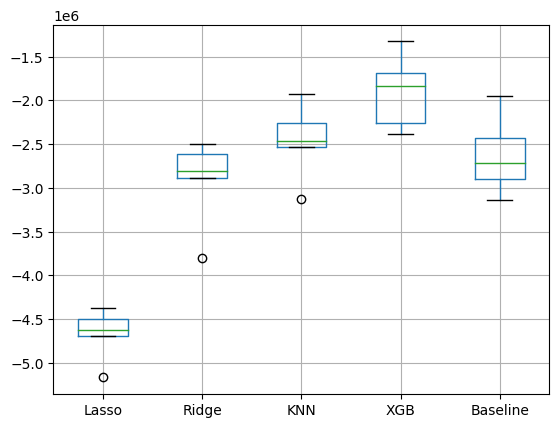

In [16]:
data = dict(map(lambda x: [x[0], x[1][1]['test_score']], model_scores.items()))
data['Baseline'] = baseline_scores['test_score']

pd.DataFrame(data).boxplot()